In [258]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split,KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from warnings import WarningMessage
import warnings
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore",message="pkg_resources is deprecated as an API")

### Importation de la base de données

In [259]:
df=pd.read_csv("dataset/cleaned_dataset_v2.csv")

In [260]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [208]:
# 1. Avant de séparer train/test, encode les clusters
#cluster_dummies = pd.get_dummies(df['Cluster'], prefix='Cluster', drop_first=True)
# Cela crée : cluster_2, cluster_3, cluster_4 (cluster_1 est la référence)
# 2. Ajoute ces colonnes à ton DataFrame
#df = pd.concat([df, cluster_dummies], axis=1)
# 3. Supprime la colonne cluster originale
#df = df.drop('Cluster', axis=1)

Ici nous nous interressons à la prédiction de montant total facturé TotalCharge et nous incluons pas la vaiable Churn dans le modèle de regression car elle représente notre variable dépendante pour le problème de Classification. Plusieurs modeles seront testés et optimisés et comparés entre eux pour choisir le modèle le plus optimal selon les métriques qu'on définira dans la suite

In [261]:
X = df.drop(["TotalCharges","Churn"], axis=1)
y = df["TotalCharges"]

On coupe le jeu de données en jeu de d'apprentissage et test sur la base de 80/20

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [263]:
cols_to_scale = ["tenure", "MonthlyCharges"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

### **Knn**

Nous commencons par un modele de regression KNN simple sans optimisation des hyperparametres. L'erreur quadratique moyenne et le coefficient de détermination sont utilisés pour évaluer la qualité prédictive du modèle

#### Modèle naif sans optimisation

In [242]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse_knn = np.sqrt(mse)
mae_knn = mean_absolute_error(y_test, y_pred)
print("RMSE :", rmse_knn, "MAE :", mae_knn)

RMSE : 461.51023786382336 MAE : 306.8306422995032


#### Recherche d'hyperparamètre

A présent, nous allons essayer d'améliorer le modele naif précedent en allant à la recherche des hyperparamètres tout en contrôlant le surapprentissage par la validation croisée afin de garantir la robustesse des résultats.

In [243]:
knn = KNeighborsRegressor()
# Grille d'hyperparamètres 
param_grid = {"n_neighbors": list(range(3, 31)),"weights": ["uniform", "distance"],"p": [1, 2]}
# GridSearchCV avec validation croisée
grid_knn = GridSearchCV(knn,param_grid,cv=10,scoring="neg_mean_squared_error",n_jobs=-1)
# Entraînement du modèle
grid_knn.fit(X_train_scaled, y_train)
# Meilleurs paramètres 
best_params_knn = grid_knn.best_params_
print("Meilleurs paramètres KNN :", best_params_knn)

/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPi

Meilleurs paramètres KNN : {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


Avec une validation croisée de 10 fold, la recherche d'hyperparamètre a identifié que le modele KNN est perfomant en utilisant 15 voisins, une distance euclidienne et des poids proportionnels à la distance

#### Modele Optimal

In [246]:
# Modèle optimisé
knn_opt = KNeighborsRegressor(n_neighbors=best_params_knn["n_neighbors"],weights=best_params_knn["weights"],p=best_params_knn["p"])
# Entraînement
knn_opt.fit(X_train_scaled, y_train)
# Prédictions
y_pred_opt = knn_opt.predict(X_test_scaled)
# Évaluation
rmse_knn_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
mae_knn_opt = mean_absolute_error(y_test, y_pred_opt)
print(f"RMSE KNN optimisé : {rmse_knn_opt:.2f}, MAE : {mae_knn_opt:.3f}")

RMSE KNN optimisé : 382.31, MAE : 257.648


### **Random Forest**

#### Modele de référence sans optimisation de paramètres

In [264]:
# Modèle de base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# Entraînement
rf.fit(X_train, y_train)
# Prédiction
y_pred_rf = rf.predict(X_test)
# Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf=mae_knn = mean_absolute_error(y_test, y_pred_rf)
print(f"RMSE RF de base : {rmse_rf:.2f}, MAE RF : {mae_rf:.3f}")

RMSE RF de base : 80.80, MAE RF : 53.354


#### Recherche d'hyperparamètres

In [252]:
# Modèle de base
rf = RandomForestRegressor(random_state=42)
# Grille d’hyperparamètres
# Grille d’hyperparamètres sécurisée
param_grid = {'n_estimators': [100, 200, 300],'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [2, 4, 6],'max_features': ['sqrt', 'log2'],'bootstrap': [True]}
# GridSearch avec 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=10,scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=1)
# Entraînement
grid_search.fit(X_train, y_train)
# Meilleurs paramètres et performances
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_
print("Meilleurs paramètres RF :", best_params)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPi

Meilleurs paramètres RF : {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300}


#### Modèle Optimal

In [257]:
# Modèle optimisé
rf_opt = RandomForestRegressor(bootstrap=True, max_depth=15, max_features='sqrt', min_samples_leaf=2, n_estimators= 300)
# Entraînement
rf_opt.fit(X_train, y_train)
# Prédiction sur le test set
y_pred_rf_opt = rf_opt.predict(X_test)
# Évaluation des performances
rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
r2_rf_opt = r2_score(y_test, y_pred_rf_opt)
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)
print(f"RMSE RF optimisé sur test : {rmse_rf_opt:.2f}")
print(f"R2 RF optimisé sur test : {r2_rf_opt:.3f}")
print(f"MAE optimisé sur test : {mae_rf_opt:.3f}")

RMSE RF optimisé sur test : 300.23
R2 RF optimisé sur test : 0.983
MAE optimisé sur test : 199.597


### **XGBOOST**

Après avoir testé des méthodes basées sur le voisinage (KNN) et sur l’agrégation d’arbres (Random Forest), nous mettons en œuvre un modèle de boosting, XGBoost

#### Modele de référence sans optimisation de paramètres

In [266]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=123)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"RMSE XGBoost : {rmse_xgb:.2f}, R2 : {r2_xgb:.3f}, MAE : {mae_xgb:.3f}")

RMSE XGBoost : 86.59, R2 : 0.999, MAE : 57.391


#### Recherche d'hyperparamètres

In [267]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=123)
# Hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'max_depth': [3, 6, 10],  # Profondeur maximale des arbres
    'learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
    'subsample': [0.8, 1.0],  # Fraction d'exemples utilisés pour chaque arbre
    'colsample_bytree': [0.8, 1.0],  # Fraction de colonnes utilisées pour chaque arbre
    'gamma': [0, 0.1, 0.2]  # Paramètre de régularisation
}
# Initialisation du GridSearchCV avec une validation croisée à 5 plis
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
# Entraîner le modèle avec la recherche par grille
grid_search.fit(X_train, y_train)
# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
# Meilleur modèle trouvé par GridSearchCV
best_xgb_model = grid_search.best_estimator_

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPi

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s


#### Modele Optimal

RMSE XGBoost : 78.85, MAE : 51.847


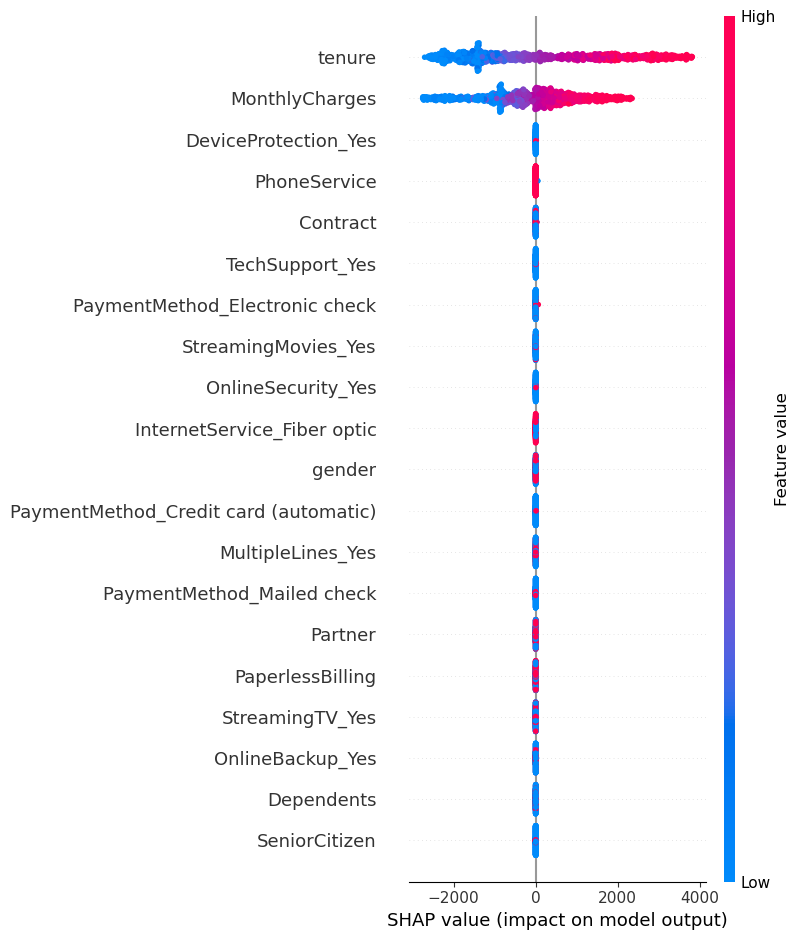

In [269]:
# Modèle XGBoost optimal
xgb_optimal = xgb.XGBRegressor(objective='reg:squarederror',random_state=123,n_estimators=100,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=1.0,gamma=0)
# Entraînement
xgb_optimal.fit(X_train, y_train)
# Prédictions
y_pred_xgb = xgb_optimal.predict(X_test)
# Évaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"RMSE XGBoost : {rmse_xgb:.2f}, MAE : {mae_xgb:.3f}")
# Visualisation de l'importance des variables
import shap
# Initialiser l'explainer SHAP avec le modèle XGBoost entraîné
explainer = shap.Explainer(xgb_optimal)
# Calculer les valeurs SHAP pour le jeu de données de test
shap_values = explainer(X_test)
# Afficher un graphique récapitulatif des valeurs SHAP
#shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)
#shap.plots.bar(shap_values)

Le diagramme SHAP met en évidence les variables les plus influentes sur la prédiction du montant total facturé. L’ancienneté du client (tenure) et le cluster d’appartenance apparaissent comme les principaux facteurs explicatifs, tandis que les charges mensuelles et certains services comme la fibre optique ou la protection des appareils contribuent également de manière significative. La couleur indique la valeur réelle de chaque variable, confirmant que des valeurs plus élevées de tenure et MonthlyCharges entraînent une augmentation de la prédiction.

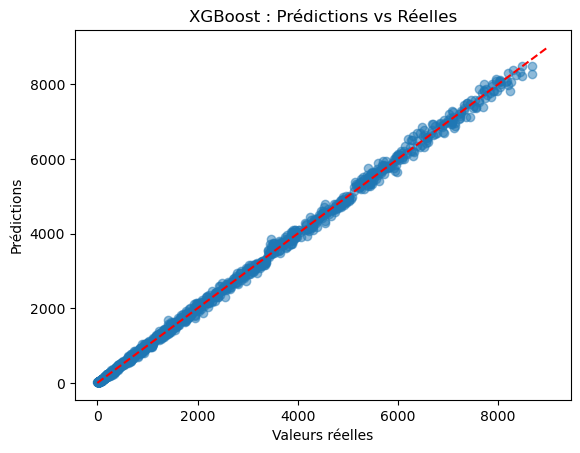

In [186]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([0, 9000], [0, 9000], 'r--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("XGBoost : Prédictions vs Réelles")
plt.show()
